# Individual assignment : Sébastien PAVOT

## Open data sources: Western EUROPE

### Goal : From the open data sources on the internet, collect and analyze the trend of housing price in Europe from 2005. Figure out and explain the factors (e.g. Economic, Finance, Demographic, Housing market, etc.) effecting the price. Visualize the data using an interactive dashboard and map

Note:
- At least 5 countries:
     - Austria
     - Belgium
     - France
     - Germany
     - Liechtenstein --> not in eurostat
     - Luxembourg
     - Monaco --> not in eurostat
     - Netherlands
     - Switzerland --> not in eurostat

## Process : 
- Collect data: Internet. Target region: Western Europe
- Process data: Pandas
- Present data: Plot.ly - Dash

## Method:

- Build a simple linear model to explain the relationship between the housing price and the factors

## Data sources:
- United Nations geoscheme for Europe
https://en.wikipedia.org/wiki/United_Nations_geoscheme_for_Europe

- Numbeo
http://www.numbeo.com/common/

- eurostat
http://ec.europa.eu/eurostat/web/main/home

- OECD.Stat
http://stats.oecd.org/

- GlobalPropertyGuide
http://www.globalpropertyguide.com/ 


- Plot.ly - Dash library
https://plot.ly/dash/

##### Comments : We're going to use 18 variables for 6 countries in order to analyze their relationship with the house index price per year of each country between 2005 & 2018. Some data are missing for some countries for some periods and are replaced with the mean.

# Libraries & packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


In [2]:
pip install dash

Note: you may need to restart the kernel to use updated packages.


In [3]:
directory = "C:/Users/spavot/Documents/GitHub/financiaprogrammingindividual"
inputdataFrance = directory + "/Data"

# Data importation

First, we define an array containing the name of all country we're going to analyse.
We're going to use this array later in the code.

In [4]:
country =  ['Germany','France','Austria','Belgium','Luxembourg','Netherlands']

### Excel files

Regarding the data we downloaded, we have 2 types of files: Excel and CSV. In this first part, we focus on importing and cleaning the data from Excel files.

##### House price index 

Housr price index come from the Eurostat website, we're going to use the data from 2005 to 2018.

In [5]:
house_price = pd.read_excel(inputdataFrance+'/House price index.xlsx')

In [6]:
#In order to clean the data, we first need to transpose the data, then we define the columns name as the the first columns value.
house_price = house_price.transpose()
house_price.columns = house_price.iloc[0]

#Then , we rename Germany columns which as a really long name only to Germany.
house_price = house_price.rename(columns = {"Germany (until 1990 former territory of the FRG)":"Germany"})

#Now, we only keep the country we wanted based on the columns names.
house_price = house_price[['France','Austria','Belgium','Germany','Luxembourg'\
    ,'Netherlands']]

#As the dataset contains information we didn't wanted and they transformed into NA value after the transpose, we drop them.
house_price = house_price.dropna()

#We don't want anymore the first column so we drop it.
house_price = house_price[1:]

#Some missing values are represented in this dataset with ':', we change them into 0 to identify them easily.
house_price.loc[house_price['Austria'] == ':', 'Austria'] = 0
house_price.loc[house_price['Luxembourg'] == ':', 'Luxembourg'] = 0
house_price.head()

time,France,Austria,Belgium,Germany,Luxembourg,Netherlands
2005-Q1,79.81,0,69.68,84.2,0,104.46
2005-Q2,83.19,0,71.24,82.7,0,105.66
2005-Q3,87.1,0,73.78,84.4,0,107.07
2005-Q4,88.77,0,75.24,82,0,107.59
2006-Q1,90.81,0,76.7,83.2,0,108.78


In [7]:
#Now, we reset the index as the index was the year and quarter.
house_price = house_price.reset_index()
#And we give a name to the new column created.
house_price = house_price.rename(columns = {"index":"Year"})

In [8]:
#This for loop transform all quarters into year in order to be able to do a groupby per year/
for y in range(1,5):
    for z in range(2005,2020):
        a = str(z)+'-Q'+ str(y)
        house_price.loc[house_price['Year'] == str(a), 'Year'] = str(z)
house_price.head()

time,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,2005,79.81,0,69.68,84.2,0,104.46
1,2005,83.19,0,71.24,82.7,0,105.66
2,2005,87.1,0,73.78,84.4,0,107.07
3,2005,88.77,0,75.24,82,0,107.59
4,2006,90.81,0,76.7,83.2,0,108.78


In [9]:
#Before doing the groupby, we need to transform all value into integer or float.
#This for loop change Year columns into integer and all other values into float.
for col in house_price:
    if str(col) == 'Year':
        house_price[col] = house_price[col].astype('int')
    else:
        house_price[col] = house_price[col].astype('float')
house_price.head()

time,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,2005,79.81,0.0,69.68,84.2,0.0,104.46
1,2005,83.19,0.0,71.24,82.7,0.0,105.66
2,2005,87.10,0.0,73.78,84.4,0.0,107.07
3,2005,88.77,0.0,75.24,82.0,0.0,107.59
4,2006,90.81,0.0,76.70,83.2,0.0,108.78


In [10]:
#As we want value per year because other dataset that we're going to use are per year, we group by year by doing mean of value.
house_price = house_price.groupby('Year').mean()

In [11]:
#We reset index and now we obtain our final and cleaned dataset.
house_price = house_price.reset_index()

In [12]:
house_price.head()

time,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500


##### Unemployment rates

We now import another dataset about Unemployement rates from Eurostat.

In [13]:
unempl_rate = pd.read_excel(inputdataFrance+'/unemployment rate.xlsx')

In [14]:
unempl_rate.head()

,time,1995,Unnamed: 2,1996,Unnamed: 4,1997,Unnamed: 6,1998,Unnamed: 8,1999,...,2014,Unnamed: 40,2015,Unnamed: 42,2016,Unnamed: 44,2017,Unnamed: 46,2018,Unnamed: 48
0,geo (Labels),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Belgium,9.7,NaN,9.5,NaN,9.2,NaN,9.3,NaN,8.4,...,8.5,NaN,8.5,NaN,7.8,NaN,7.1,b,6.0,NaN
2,Bulgaria,:,NaN,:,NaN,:,NaN,:,NaN,:,...,11.4,NaN,9.2,NaN,7.6,NaN,6.2,NaN,5.2,NaN
3,Czechia,4,NaN,3.9,NaN,4.8,NaN,6.5,NaN,8.7,...,6.1,NaN,5.1,NaN,4.0,NaN,2.9,NaN,2.2,NaN
4,Denmark,6.7,NaN,6.3,NaN,5.2,NaN,4.9,NaN,5.2,...,6.9,NaN,6.3,NaN,6.0,NaN,5.8,NaN,5.1,NaN


In [15]:
#As above, the dataset is in the same format at the basis as House index price as it comes from the same website.
#Main difference is that data is per year, so we do the same operation as above but we don't change quarter into year.
#And we don't need to do a groupby because data is already per year.
unempl_rate = unempl_rate.transpose()
unempl_rate.columns = unempl_rate.iloc[0]
unempl_rate = unempl_rate.rename(columns = {"Germany (until 1990 former territory of the FRG)":"Germany"})
unempl_rate = unempl_rate[['France','Austria','Belgium','Germany','Luxembourg'\
    ,'Netherlands']]
unempl_rate = unempl_rate.dropna()
unempl_rate = unempl_rate[1:]
unempl_rate = unempl_rate.reset_index()
unempl_rate = unempl_rate.rename(columns = {"index":"Year"})
for col in unempl_rate:
    if str(col) == 'Year':
        unempl_rate[col] = unempl_rate[col].astype('int')
    else:
        unempl_rate[col] = unempl_rate[col].astype('float')
#And we obtain our final dataset per year for each country we wanted.
unempl_rate.head()

time,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,1995,10.2,4.2,9.7,8.2,2.9,8.3
1,1996,10.5,4.7,9.5,8.9,2.9,7.7
2,1997,10.7,4.7,9.2,9.6,2.7,6.5
3,1998,10.3,4.7,9.3,9.4,2.7,5.1
4,1999,10.0,4.2,8.4,8.6,2.4,4.2


##### Exchanges rates

As the Unemployement rates, exchanges rates comes also from Eurostat. So the dataset is the same format so we do exactly the same manipulation as above.

In [16]:
exchanges_rates = pd.read_excel(inputdataFrance+'/Nominal exchange rates.xlsx')

In [17]:
exchanges_rates = exchanges_rates.transpose()
exchanges_rates.columns = exchanges_rates.iloc[0]
exchanges_rates = exchanges_rates.rename(columns = {"Germany (until 1990 former territory of the FRG)":"Germany"})
exchanges_rates = exchanges_rates[['France','Austria','Belgium','Germany','Luxembourg'\
    ,'Netherlands']]
exchanges_rates = exchanges_rates.dropna()
exchanges_rates = exchanges_rates[1:]
exchanges_rates = exchanges_rates.reset_index()
exchanges_rates = exchanges_rates.rename(columns = {"index":"Year"})
for col in exchanges_rates:
    if str(col) == 'Year':
        exchanges_rates[col] = exchanges_rates[col].astype('int')
    else:
        exchanges_rates[col] = exchanges_rates[col].astype('float')
exchanges_rates.head()

time,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,1995,1.4,2.6,2.7,3.9,2.5,2.4
1,1996,0.0,-1.9,-2.1,-3.1,-2.0,-1.9
2,1997,-0.1,-1.0,-1.3,-1.6,-1.2,-1.4
3,1998,0.9,0.4,0.2,0.5,0.2,0.1
4,1999,0.1,0.3,0.1,0.3,0.1,0.2


##### Electricity consumption

Tonne of equivalent oil consumption of electricity per year per country. Here, the data come from an other website not mentionned so we need to do special manipulation for this data set.

In [18]:
electricity = pd.read_excel(inputdataFrance+'/data-elec.xlsx')

In [19]:
#We first drop all columns containing values we don't want, we only focus on electricity consumption per year.
electricity = electricity.drop(columns = ['Product','Flow','NoCountry','NoProduct','NoFlow'])

In [20]:
#As we want the dataset per country, we transpose it.
electricity = electricity.transpose()
#And define the columns name by the first columns of the dataset.
electricity.columns = electricity.iloc[0]
#We only keep the country we analyze.
electricity = electricity[['France','Austria','Belgium','Germany','Luxembourg'\
    ,'Netherlands']]
#We drop NA values.
electricity = electricity.dropna()
#And drop the first columns as we don't need it anymore.
electricity = electricity[1:]
electricity.head()

Country,France,Austria,Belgium,Germany,Luxembourg,Netherlands
1971,10854.9,1874.81,2395.27,23284.8,223.646,3243.94
1972,11676,2020.72,2672.74,25180.1,236.973,3564.49
1973,12779.4,2175.32,2941.01,26905.2,255.116,3812.81
1974,13508.1,2271.02,3116.68,27971.4,294.325,4073.52
1975,13561.7,2258.73,2937.92,27644.6,267.498,4119.6


In [21]:
#We reset the index to have year as a column, and have a proper index.
electricity = electricity.reset_index()
#And rename columns for more clarity.
electricity = electricity.rename(columns = {"index":"Year", 'Country':''})
#Now, this loop make sure that all year are integer and other values for each country are float.
for col in electricity:
    if str(col) == 'Year':
        electricity[col] = electricity[col].astype('int')
    else:
        electricity[col] = electricity[col].astype('float')
electricity.head()

Country,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,1971,10854.8581,1874.8065,2395.2709,23284.7807,223.6457,3243.9381
1,1972,11676.0103,2020.7223,2672.7429,25180.1376,236.9733,3564.4884
2,1973,12779.3637,2175.3224,2941.0146,26905.2451,255.1161,3812.8117
3,1974,13508.0825,2271.0232,3116.6810,27971.3672,294.3250,4073.5168
4,1975,13561.6509,2258.7274,2937.9192,27644.6260,267.4979,4119.6045


##### Fertility rate

As above, the fertility rate per country per year come from an other website (same as above) so we're going to apply the same code to clean the data. (this is why we don't explain again the method to clean the data)

In [22]:
fertility = pd.read_excel(inputdataFrance+'/fertility-rate.xls')

In [23]:
fertility = fertility.drop(columns = ['Country Code','Indicator Name','Indicator Code'])

In [24]:
fertility = fertility.transpose()
fertility.head()
fertility.columns = fertility.iloc[0]
fertility = fertility[['France','Austria','Belgium','Germany','Luxembourg'\
    ,'Netherlands']]
fertility = fertility.dropna()
fertility = fertility[1:]
fertility = fertility.reset_index()
fertility = fertility.rename(columns = {"index":"Year", 'Country':''})
for col in fertility:
    if str(col) == 'Year':
        fertility[col] = fertility[col].astype('int')
    else:
        fertility[col] = fertility[col].astype('float')
fertility.head()

Country Name,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,1960,2.85,2.69,2.54,2.37,2.29,3.12
1,1962,2.89,2.80,2.59,2.44,2.37,3.18
2,1964,2.87,2.79,2.71,2.54,2.34,3.17
3,1965,2.84,2.70,2.61,2.50,2.42,3.04
4,1966,2.80,2.66,2.52,2.53,2.34,2.90


##### Stock market value


Once more, the stock market value is in the same format as fertility rate so the code to manipulate the data is the same to obtain a nice and clean dataset.

In [25]:
Stock_market = pd.read_excel(inputdataFrance+'/stock-market.xls')

In [26]:
Stock_market = Stock_market.drop(columns = ['Country Code','Indicator Name','Indicator Code'])
Stock_market = Stock_market.transpose()
Stock_market.head()
Stock_market.columns = Stock_market.iloc[0]
Stock_market = Stock_market[['France','Austria','Belgium','Germany','Luxembourg'\
    ,'Netherlands']]
Stock_market = Stock_market.dropna()
Stock_market = Stock_market[1:]
Stock_market = Stock_market.reset_index()
Stock_market = Stock_market.rename(columns = {"index":"Year", 'Country':''})
for col in Stock_market:
    if str(col) == 'Year':
        Stock_market[col] = Stock_market[col].astype('int')
    else:
        Stock_market[col] = Stock_market[col].astype('float')
Stock_market.head()

Country Name,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,1975,3.529995e+10,1.300010e+09,9.000100e+09,5.140031e+10,8.000000e+08,1.830002e+10
1,1976,2.739977e+10,1.500040e+09,9.400050e+09,5.339979e+10,8.000000e+08,2.019999e+10
2,1977,2.792858e+10,1.489940e+09,1.029133e+10,6.510113e+10,8.618500e+08,2.251825e+10
3,1978,4.538236e+10,1.744944e+10,1.250716e+10,8.369166e+10,1.046590e+09,2.657614e+10
4,1979,5.525408e+10,2.080280e+09,1.373438e+10,7.939994e+10,2.540000e+09,2.919759e+10


##### Perception of corruption

This data contains information about perception of corruption from the population, it comes from an other website and need special manipulation.

In [27]:
Corruption = pd.read_excel(inputdataFrance+'/Corruption.xlsm')

In [28]:
Corruption.head()

,Country name,Year,Perceptions of corruption
0,Afghanistan,2008,0.881686
1,Afghanistan,2009,0.850035
2,Afghanistan,2010,0.706766
3,Afghanistan,2011,0.731109
4,Afghanistan,2012,0.775620


In [29]:
#To obtain value per country, with a column year, we pivot the dataset and year will be the index where countries
#will be the columns and the values will be the perception of corruption column.
Corruption = Corruption.pivot(index='Year', columns='Country name', values='Perceptions of corruption')

In [30]:
#Now we filter to only keep the countries we wanted.
Corruption =  Corruption[['France','Austria','Belgium','Germany','Luxembourg'\
    ,'Netherlands']]

In [31]:
#We reset the index to obtain year as a column.
Corruption =  Corruption.reset_index()

In [32]:
Corruption.head()
#Check missing values.

Country name,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,2005,0.687851,NaN,0.597554,0.781007,NaN,0.571342
1,2006,0.699270,0.490111,NaN,NaN,NaN,NaN
2,2007,NaN,NaN,0.721093,0.792179,NaN,0.445437
3,2008,0.668876,0.613625,0.651801,0.758266,NaN,0.418940
4,2009,0.654168,NaN,NaN,0.689931,0.431607,NaN


##### Confidence in the government 

This dataset comes from the same source as above so we do excactly the same manipulation than for corruption. So we don't explain manipulation again.

In [33]:
confidence = pd.read_excel(inputdataFrance+'/confidence-gov.xls')

In [34]:
confidence = confidence.pivot(index = 'Year', columns = 'Country name', values = 'Confidence in national government')

In [35]:
confidence =  confidence[['France','Austria','Belgium','Germany','Luxembourg'\
    ,'Netherlands']]

In [36]:
confidence = confidence.reset_index()
confidence.head()

Country name,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,2005,0.324884,NaN,0.551705,0.321759,NaN,0.429007
1,2006,0.361353,0.497038,NaN,NaN,NaN,NaN
2,2007,NaN,NaN,0.602238,0.349765,NaN,0.661946
3,2008,0.452659,0.257242,0.463137,0.357918,NaN,0.617429
4,2009,0.474449,NaN,NaN,0.519231,0.824018,NaN


##### Life ladder

Once more, this dataset came as the format as above so it needs the same manipulation. It contains data about Life ladder per country per year.

In [37]:
life_ladder = pd.read_excel(inputdataFrance+'/life ladder.xlsx')

In [38]:
life_ladder = life_ladder.pivot(index = 'Year', columns = 'Country name', values = 'Life Ladder')
life_ladder =  life_ladder[['France','Austria','Belgium','Germany','Luxembourg'\
    ,'Netherlands']]
life_ladder = life_ladder.reset_index()
life_ladder.head()

Country name,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,2005,7.093393,NaN,7.262290,6.619550,NaN,7.463979
1,2006,6.582700,7.122211,NaN,NaN,NaN,NaN
2,2007,NaN,NaN,7.218840,6.416820,NaN,7.451880
3,2008,7.008065,7.180954,7.116591,6.521790,NaN,7.631012
4,2009,6.283498,NaN,NaN,6.641493,6.95792,NaN


##### Inflation

This dataset comes from OECD website, so we need to do manipulation not done before as the dataset don't came in the same format.

In [39]:
inflation = pd.read_excel(inputdataFrance+'/inflation.xlsx')

In [40]:
inflation.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,CPI,TOT,AGRWTH,A,2005,2.691832,NaN
1,AUS,CPI,TOT,AGRWTH,A,2006,3.555288,NaN
2,AUS,CPI,TOT,AGRWTH,A,2007,2.327611,NaN
3,AUS,CPI,TOT,AGRWTH,A,2008,4.350298,NaN
4,AUS,CPI,TOT,AGRWTH,A,2009,1.771117,NaN


In [41]:
#We define an array containing country code to use it to replace country code by the full country name.
country_code = ['DEU','FRA','AUS','BEL','LUX','NLD']

#This for loop transform all value into the column LOCATION which are equal to the country code to the full country name
#using the array we defined at the beginning of this code.
i = 0
for x in country_code:
        inflation.loc[inflation['LOCATION'] == x, 'LOCATION'] = country[i]
        i = i + 1

#Now, we transform the location columns to be equal to the value corresponding to the country.       
for i in country:
    inflation.loc[inflation['LOCATION'] == str(i), str(i)] = inflation['Value']

#We group by time to obtain value per year and columns are the country.
inflation = inflation.groupby('TIME').sum()
#We drop the value column as we don't need it anymore.
inflation = inflation.drop(columns = 'Value')
inflation.head()

,Germany,France,Austria,Belgium,Luxembourg,Netherlands
TIME,,,,,,
2005,1.546911,1.745869,2.691832,2.781433,2.487693,1.688130
2006,1.577429,1.675125,3.555288,1.791208,2.666315,1.101501
2007,2.298341,1.487998,2.327611,1.823056,2.312459,1.613859
2008,2.628383,2.812862,4.350298,4.489444,3.401880,2.486502
2009,0.312738,0.087620,1.771117,-0.053146,0.368042,1.189777


In [42]:
#We reset index to have year as a column.
inflation = inflation.reset_index()

In [43]:
#We rename columns and make sure that all values are integer for year and float for else.
inflation = inflation.rename(columns = {'TIME':"Year"})
for col in inflation:
    if str(col) == 'Year':
        inflation[col] = inflation[col].astype('int')
    else:
        inflation[col] = inflation[col].astype('float')

In [44]:
inflation.head()

,Year,Germany,France,Austria,Belgium,Luxembourg,Netherlands
0,2005,1.546911,1.745869,2.691832,2.781433,2.487693,1.688130
1,2006,1.577429,1.675125,3.555288,1.791208,2.666315,1.101501
2,2007,2.298341,1.487998,2.327611,1.823056,2.312459,1.613859
3,2008,2.628383,2.812862,4.350298,4.489444,3.401880,2.486502
4,2009,0.312738,0.087620,1.771117,-0.053146,0.368042,1.189777


##### Minimum wages

The minimum wages per country comes also from OECD but isn't is the same format so we use special manipulation for it.

In [45]:
wages = pd.read_excel(inputdataFrance+'/wages.xlsx')

In [46]:
#We define columns names to be the equals to the first columns
wages.columns = wages.iloc[0]
#We rename columns which are in float way to integer way.
wages = wages.rename(columns = {2015.0:'2015',2016.0:'2016',2017.0:'2017'})
#We drop the two first columns and transpose the data.
wages = wages[2:]
wages = wages.transpose()
#We define columns names to be equal to the first column.
wages.columns = wages.iloc[0]
#We drop the 6 first columns.
wages = wages[6:]
#We assign a new column wages for Austria equal to 0 in order to obtain this column even if values are missing for this country.
wages['Austria'] = 0
#We only keep the country wanted.
wages = wages[['France','Austria','Belgium','Germany','Luxembourg'\
    ,'Netherlands']]
#And replace missing values specified by ".." with 0.
wages.loc[wages['Germany'] == '..', 'Germany'] = 0

In [47]:
#We now reset the index.
wages = wages.reset_index()
#And rename column.
wages = wages.rename(columns = {0:'Year'})
#And change type for all of the values.
for col in wages:
    if str(col) == 'Year':
        wages[col] = wages[col].astype('int')
    else:
        wages[col] = wages[col].astype('float')

In [48]:
wages.head()

Time,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,2005,19414.10,0.0,21413.56,0.0,22631.66,22855.03
1,2006,19900.01,0.0,21454.01,0.0,22501.21,22851.51
2,2007,20101.51,0.0,21701.65,0.0,22922.95,23023.30
3,2008,20140.51,0.0,21614.05,0.0,22630.56,23097.71
4,2009,20493.07,0.0,22684.99,0.0,23573.48,23573.39


###### Nominal exchanges rates

This dataset comes from Eurostat and is in the same format as all Eurostat dataset so we do exactly the same manipulation as we already did before.

In [49]:
ner = pd.read_excel(inputdataFrance+'/nominal exchange rates.xlsx')

In [50]:
ner = ner.transpose()
ner.columns = ner.iloc[0]
ner = ner.rename(columns = {"Germany (until 1990 former territory of the FRG)":"Germany"})
ner = ner[['France','Austria','Belgium','Germany','Luxembourg'\
    ,'Netherlands']]
ner = ner.dropna()
ner = ner[1:]
ner = ner.reset_index()
ner = ner.rename(columns = {'index':"Year"})

for col in ner:
    if str(col) == 'Year':
        ner[col] = ner[col].astype('int')
    else:
        ner[col] = ner[col].astype('float')

ner.head()

time,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,1995,1.4,2.6,2.7,3.9,2.5,2.4
1,1996,0.0,-1.9,-2.1,-3.1,-2.0,-1.9
2,1997,-0.1,-1.0,-1.3,-1.6,-1.2,-1.4
3,1998,0.9,0.4,0.2,0.5,0.2,0.1
4,1999,0.1,0.3,0.1,0.3,0.1,0.2


###### Nominal effective exchanges rates

For the nominal effective exchanges rates, it's the same, it also comes from Eurostat.

In [51]:
ner_effective = pd.read_excel(inputdataFrance+'/nominal effective exchange rates.xlsx')

In [52]:
ner_effective = ner_effective.transpose()
ner_effective.columns = ner_effective.iloc[0]
ner_effective = ner_effective.rename(columns = {"Germany (until 1990 former territory of the FRG)":"Germany"})
ner_effective = ner_effective[['France','Austria','Belgium','Germany','Luxembourg'\
    ,'Netherlands']]
ner_effective = ner_effective.dropna()
ner_effective = ner_effective[1:]

ner_effective = ner_effective.reset_index()
ner_effective = ner_effective.rename(columns = {'index':"Year"})

for col in ner_effective:
    if str(col) == 'Year':
        ner_effective[col] = ner_effective[col].astype('int')
    else:
        ner_effective[col] = ner_effective[col].astype('float')
ner_effective.head()

time,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,1995,6.4,7.6,6.7,9.9,6.4,6.6
1,1996,1.0,-0.4,-1.4,-0.9,-1.4,-1.2
2,1997,-3.1,-1.4,-3.8,-3.4,-3.6,-3.6
3,1998,3.4,3.3,2.0,3.8,1.4,2.0
4,1999,0.2,2.0,0.4,1.9,0.4,0.8


##### Gross domestic product data per people.

GDP Data also comes from Eurostat in Excel format so we do the same manipulation that we explained before for the files of the same source and in the same format.

In [53]:
GDP = pd.read_excel(inputdataFrance+'/GDP.xlsx')
GDP = GDP.transpose()
GDP.columns = GDP.iloc[0]
GDP = GDP.rename(columns = {"Germany (until 1990 former territory of the FRG)":"Germany"})
GDP = GDP[['France','Austria','Belgium','Germany','Luxembourg'\
    ,'Netherlands']]
GDP = GDP.dropna()
GDP = GDP[1:]

GDP = GDP.reset_index()
GDP = GDP.rename(columns = {'index':"Year"})

for col in GDP:
    if str(col) == 'Year':
        GDP[col] = GDP[col].astype('int')
    else:
        GDP[col] = GDP[col].astype('float')
GDP.head()

time,Year,France,Austria,Belgium,Germany,Luxembourg,Netherlands
0,2007,30330.0,34230.0,32340.0,30860.0,77340.0,37800.0
1,2008,30960.0,35300.0,32840.0,31530.0,77940.0,39350.0
2,2009,29930.0,34530.0,32090.0,30390.0,74220.0,37800.0
3,2010,30690.0,35390.0,33330.0,31940.0,79160.0,38470.0
4,2011,31510.0,36970.0,34200.0,33550.0,83100.0,38960.0


### CSV files

Here, we import and clean the data coming from CSV files.

###### Crime Data

In [54]:
crime =  pd.read_csv(inputdataFrance + '/crime data.csv', sep = ',')

In [55]:
crime.head()

,TIME,GEO,HHTYP,INCGRP,UNIT,Value,Flag and Footnotes
0,2008,Austria,Total,Total,Percentage,11.0,b
1,2008,Belgium,Total,Total,Percentage,15.8,NaN
2,2008,Bulgaria,Total,Total,Percentage,24.7,NaN
3,2008,Switzerland,Total,Total,Percentage,12.2,NaN
4,2008,Cyprus,Total,Total,Percentage,10.1,b


In [56]:
#We rename column and treat missing values.
crime.loc[crime['GEO'] == "Germany (until 1990 former territory of the FRG)", 'GEO'] = 'Germany'
crime.loc[crime['Value'] == ':', 'Value'] = 0
#And transform the column to numeric.
crime['Value'] = pd.to_numeric(crime['Value'])

In [57]:
#This function change the value of a column called "geo" of a dataset to the value corresponding to the country
#using the array we define at the begining with all the country. And then, replace NA value with 0.
def EuroStatCSV(dataset,geo,country, value):
    for i in country:
        dataset.loc[dataset[geo] == str(i), str(i)] = dataset[value]
    dataset = dataset.fillna(0)

In [58]:
#We use the function for crime data.
EuroStatCSV(crime,geo = 'GEO',country = country,value = 'Value')
#And now groupby "TIME" which is the year
crime = crime.groupby('TIME').sum()
#And drop the value column.
crime = crime.drop(columns = 'Value')

In [59]:
#We reset the index and rename the year column and after we make sure every data is in the good format.
crime = crime.reset_index()
crime = crime.rename(columns = {'TIME':"Year"})

for col in crime:
    if str(col) == 'Year':
        crime[col] = crime[col].astype('int')
    else:
        crime[col] = crime[col].astype('float')

crime.head()


,Year,Germany,France,Austria,Belgium,Luxembourg,Netherlands
0,2008,13.0,14.8,11.0,15.8,10.6,14.8
1,2009,12.7,15.3,15.1,16.9,10.6,21.7
2,2010,12.0,15.6,13.4,17.5,10.2,16.8
3,2011,12.9,14.8,12.1,15.6,10.7,18.6
4,2012,12.5,14.7,11.7,14.5,14.4,18.3


###### Crime urban Data

As the crime urban data also comes from Eurostat and is in the CSV format, we do the same manipulation as above.

In [60]:
crime_urban =  pd.read_csv(inputdataFrance + '/crime urban data.csv', sep = ',')

In [61]:
crime_urban.loc[crime_urban['GEO'] == "Germany (until 1990 former territory of the FRG)", 'GEO'] = 'Germany'
crime_urban.loc[crime_urban['Value'] == ':', 'Value'] = 0
crime_urban['Value'] = pd.to_numeric(crime_urban['Value'])
EuroStatCSV(crime_urban,geo = 'GEO',country = country,value = 'Value')
crime_urban = crime_urban.groupby('TIME').sum()
crime_urban = crime_urban.drop(columns = 'Value')
crime_urban = crime_urban.reset_index()
crime_urban = crime_urban.rename(columns = {'TIME':"Year"})

for col in crime_urban:
    if str(col) == 'Year':
        crime_urban[col] = crime_urban[col].astype('int')
    else:
        crime_urban[col] = crime_urban[col].astype('float')
crime_urban.head()

,Year,Germany,France,Austria,Belgium,Luxembourg,Netherlands
0,2009,27.9,30.9,21.4,32.5,16.6,29.8
1,2010,26.0,35.0,21.6,27.4,17.4,24.0
2,2011,27.4,34.3,20.1,28.4,21.8,26.8
3,2012,29.3,26.0,18.3,32.8,14.4,25.0
4,2013,30.6,34.2,20.3,37.3,11.8,21.5


##### Life expectancy Data

Life expectancy comes also from Eurostat but in this file, we had the life expectancy per gender and as total so the speicific things here to manipulate and clean the data is to make sure to only select value corresponding to the total and not for a specific gender.

In [62]:
life_expect =  pd.read_csv(inputdataFrance + '/Life expectancy data.csv', sep = ',')

In [63]:
life_expect.loc[life_expect['GEO'] == "Germany (until 1990 former territory of the FRG)", 'GEO'] = 'Germany'
life_expect.loc[life_expect['Value'] == ':', 'Value'] = 0
life_expect['Value'] = life_expect['Value'].str.replace(",", "")
life_expect['Value'] = pd.to_numeric(life_expect['Value'])
for i in country:
    life_expect.loc[(life_expect['GEO'] == str(i)) & (life_expect['SEX'] == 'Total'), str(i)] = life_expect['Value']
life_expect = life_expect.fillna(0)
life_expect = life_expect.groupby('TIME').sum()
life_expect = life_expect.drop(columns = 'Value')

life_expect = life_expect.reset_index()
life_expect = life_expect.rename(columns = {'TIME':"Year"})

for col in life_expect:
    if str(col) == 'Year':
        life_expect[col] = life_expect[col].astype('int')
    else:
        life_expect[col] = life_expect[col].astype('float')
life_expect.head()

,Year,Germany,France,Austria,Belgium,Luxembourg,Netherlands
0,2008,80.2,81.4,80.6,79.8,80.7,80.5
1,2009,80.3,81.5,80.5,80.2,80.8,80.9
2,2010,80.5,81.8,80.7,80.3,80.8,81.0
3,2011,80.6,82.3,81.1,80.7,81.1,81.3
4,2012,80.7,82.1,81.1,80.5,81.5,81.2


###### Marriage Data

Marriage data is also an Eurostat CSV file so we do the same manipulation than for this type of file

In [64]:
marriage =  pd.read_csv(inputdataFrance + '/marriage data.csv', sep = ',')

In [65]:
marriage.loc[marriage['GEO'] == "Germany (until 1990 former territory of the FRG)", 'GEO'] = 'Germany'
marriage.loc[marriage['Value'] == ':', 'Value'] = 0
marriage['Value'] = marriage['Value'].str.replace(",", "")
marriage['Value'] = pd.to_numeric(marriage['Value'])
EuroStatCSV(marriage,geo = 'GEO',country = country,value = 'Value')
marriage = marriage.groupby('TIME').sum()
marriage = marriage.drop(columns = 'Value')

marriage = marriage.reset_index()
marriage = marriage.rename(columns = {'TIME':"Year"})

for col in marriage:
    if str(col) == 'Year':
        marriage[col] = marriage[col].astype('int')
    else:
        marriage[col] = marriage[col].astype('float')
        
marriage.head()

,Year,Germany,France,Austria,Belgium,Luxembourg,Netherlands
0,2008,377122.12,265613.21,35289.36,45678.07,1983.21,74097.24
1,2009,378506.43,251721.39,35536.17,43368.45,1804.95,72186.33
2,2010,382051.70,251780.89,37549.50,42224.42,1815.85,75466.22
3,2011,377884.24,237042.86,36493.98,41004.70,1780.85,71639.50
4,2012,387427.80,241003.70,38660.40,42201.80,1785.40,70319.20


##### Pollution data

And pollution data also.

In [66]:
pollution =  pd.read_csv(inputdataFrance + '/pollution data.csv', sep = ',')

In [67]:
pollution.loc[pollution['GEO'] == "Germany (until 1990 former territory of the FRG)", 'GEO'] = 'Germany'
pollution.loc[pollution['Value'] == ':', 'Value'] = 0
pollution['Value'] = pollution['Value'].str.replace(",", "")
pollution['Value'] = pd.to_numeric(pollution['Value'])
pollution['Value'] = pollution['Value']/100
EuroStatCSV(pollution,geo = 'GEO',country = country,value = 'Value')
pollution = pollution.groupby('TIME').sum()
pollution = pollution.drop(columns = 'Value')

pollution = pollution.reset_index()
pollution = pollution.rename(columns = {'TIME':"Year"})

for col in pollution:
    if str(col) == 'Year':
        pollution[col] = pollution[col].astype('int')
    else:
        pollution[col] = pollution[col].astype('float')
        
pollution.head()

,Year,Germany,France,Austria,Belgium,Luxembourg,Netherlands
0,2009,0.325,0.205,0.118,0.280,0.267,0.221
1,2010,0.337,0.232,0.123,0.249,0.211,0.222
2,2011,0.324,0.197,0.142,0.287,0.220,0.158
3,2012,0.312,0.178,0.136,0.319,0.250,0.229
4,2013,0.360,0.208,0.192,0.332,0.210,0.218


# Merging data

Here, we're merging data that we imported before into a new dataset containing all the data for all country.

For each dataset, we're going to do a left join on Year column based on the dataset previously created and we're going to rename columns as they we're previously only the country name into the country name and the type of information for this country.

In [68]:
market_analysis=pd.merge(house_price,exchanges_rates,'left', on='Year')
market_analysis = market_analysis.rename(columns ={'France_x':'France_houseIndex','Austria_x':'Austria_houseIndex'\
,'Belgium_x':'Belgium_houseIndex','Germany_x':'Germany_houseIndex','Luxembourg_x':'Luxembourg_houseIndex',\
'Netherlands_x':'Netherlands_houseIndex','France_y':'France_exchRates','Austria_y':'Austria_exchRates'\
,'Belgium_y':'Belgium_exchRates','Germany_y':'Germany_exchRates','Luxembourg_y':'Luxembourg_exchRates',\
'Netherlands_y':'Netherlands_exchRates'})

In [69]:
market_analysis.head()

time,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,Germany_exchRates,Luxembourg_exchRates,Netherlands_exchRates
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,0.0,0.0,0.0
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,-0.1,0.0,0.0
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,-0.2,-0.1,-0.1
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,-0.1,0.0,0.0


In [70]:
market_analysis = pd.merge(market_analysis,unempl_rate,'left','Year')


In [71]:
market_analysis = market_analysis.rename(columns ={'France':'France_unemp','Austria':'Austria_unemp'\
,'Belgium':'Belgium_unemp','Germany':'Germany_unemp','Luxembourg':'Luxembourg_unemp',\
'Netherlands':'Netherlands_unemp'})

In [72]:
market_analysis.head()

time,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,Germany_exchRates,Luxembourg_exchRates,Netherlands_exchRates,France_unemp,Austria_unemp,Belgium_unemp,Germany_unemp,Luxembourg_unemp,Netherlands_unemp
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,0.0,0.0,0.0,8.9,5.6,8.5,11.2,4.6,5.9
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,-0.1,0.0,0.0,8.8,5.3,8.3,10.1,4.6,5.0
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,-0.2,-0.1,-0.1,8.0,4.9,7.5,8.5,4.2,4.2
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1,7.4,4.1,7.0,7.4,4.9,3.7
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,-0.1,0.0,0.0,9.1,5.3,7.9,7.6,5.1,4.4


In [73]:
market_analysis = pd.merge(market_analysis,life_ladder,'left','Year')


In [74]:
market_analysis = market_analysis.rename(columns ={'France':'France_lifelad','Austria':'Austria_lifelad'\
,'Belgium':'Belgium_lifelad','Germany':'Germany_lifelad','Luxembourg':'Luxembourg_lifelad',\
'Netherlands':'Netherlands_lifelad'})

In [75]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Belgium_unemp,Germany_unemp,Luxembourg_unemp,Netherlands_unemp,France_lifelad,Austria_lifelad,Belgium_lifelad,Germany_lifelad,Luxembourg_lifelad,Netherlands_lifelad
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,8.5,11.2,4.6,5.9,7.093393,NaN,7.262290,6.619550,NaN,7.463979
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,8.3,10.1,4.6,5.0,6.582700,7.122211,NaN,NaN,NaN,NaN
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,7.5,8.5,4.2,4.2,NaN,NaN,7.218840,6.416820,NaN,7.451880
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,7.0,7.4,4.9,3.7,7.008065,7.180954,7.116591,6.521790,NaN,7.631012
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,7.9,7.6,5.1,4.4,6.283498,NaN,NaN,6.641493,6.95792,NaN


In [76]:
market_analysis = pd.merge(market_analysis,confidence,'left','Year')


In [77]:
market_analysis = market_analysis.rename(columns ={'France':'France_conf','Austria':'Austria_conf'\
,'Belgium':'Belgium_conf','Germany':'Germany_conf','Luxembourg':'Luxembourg_conf',\
'Netherlands':'Netherlands_conf'})

In [78]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Belgium_lifelad,Germany_lifelad,Luxembourg_lifelad,Netherlands_lifelad,France_conf,Austria_conf,Belgium_conf,Germany_conf,Luxembourg_conf,Netherlands_conf
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,7.262290,6.619550,NaN,7.463979,0.324884,NaN,0.551705,0.321759,NaN,0.429007
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,NaN,NaN,NaN,NaN,0.361353,0.497038,NaN,NaN,NaN,NaN
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,7.218840,6.416820,NaN,7.451880,NaN,NaN,0.602238,0.349765,NaN,0.661946
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,7.116591,6.521790,NaN,7.631012,0.452659,0.257242,0.463137,0.357918,NaN,0.617429
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,NaN,6.641493,6.95792,NaN,0.474449,NaN,NaN,0.519231,0.824018,NaN


In [79]:
market_analysis = pd.merge(market_analysis,Corruption,'left','Year')


In [80]:
market_analysis = market_analysis.rename(columns ={'France':'France_corrup','Austria':'Austria_corrup'\
,'Belgium':'Belgium_corrup','Germany':'Germany_corrup','Luxembourg':'Luxembourg_corrup',\
'Netherlands':'Netherlands_corrup'})

In [81]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Belgium_conf,Germany_conf,Luxembourg_conf,Netherlands_conf,France_corrup,Austria_corrup,Belgium_corrup,Germany_corrup,Luxembourg_corrup,Netherlands_corrup
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,0.551705,0.321759,NaN,0.429007,0.687851,NaN,0.597554,0.781007,NaN,0.571342
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,NaN,NaN,NaN,NaN,0.699270,0.490111,NaN,NaN,NaN,NaN
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,0.602238,0.349765,NaN,0.661946,NaN,NaN,0.721093,0.792179,NaN,0.445437
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,0.463137,0.357918,NaN,0.617429,0.668876,0.613625,0.651801,0.758266,NaN,0.418940
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,NaN,0.519231,0.824018,NaN,0.654168,NaN,NaN,0.689931,0.431607,NaN


In [82]:
market_analysis = pd.merge(market_analysis,Stock_market,'left','Year')


In [83]:
market_analysis = market_analysis.rename(columns ={'France':'France_stock','Austria':'Austria_stock'\
,'Belgium':'Belgium_stock','Germany':'Germany_stock','Luxembourg':'Luxembourg_stock',\
'Netherlands':'Netherlands_stock'})

In [84]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Belgium_corrup,Germany_corrup,Luxembourg_corrup,Netherlands_corrup,France_stock,Austria_stock,Belgium_stock,Germany_stock,Luxembourg_stock,Netherlands_stock
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,0.597554,0.781007,NaN,0.571342,1.758513e+12,1.262515e+11,2.884811e+11,1.202136e+12,5.124841e+10,5.928356e+11
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,NaN,NaN,NaN,NaN,2.428252e+12,1.927703e+11,3.961679e+11,1.637610e+12,7.951358e+10,7.795426e+11
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,0.721093,0.792179,NaN,0.445437,2.740341e+12,2.364484e+11,3.855529e+11,2.105198e+12,1.660780e+11,9.561576e+11
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,0.651801,0.758266,NaN,0.418940,1.472407e+12,7.628870e+10,1.672183e+11,1.110580e+12,6.661473e+10,3.887208e+11
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,NaN,0.689931,0.431607,NaN,1.946185e+12,1.140761e+11,2.597686e+11,1.292355e+12,1.050482e+11,5.591953e+11


In [85]:
market_analysis = pd.merge(market_analysis,inflation,'left','Year')


In [86]:
market_analysis = market_analysis.rename(columns ={'France':'France_infla','Austria':'Austria_infla'\
,'Belgium':'Belgium_infla','Germany':'Germany_infla','Luxembourg':'Luxembourg_infla',\
'Netherlands':'Netherlands_infla'})

In [87]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Belgium_stock,Germany_stock,Luxembourg_stock,Netherlands_stock,Germany_infla,France_infla,Austria_infla,Belgium_infla,Luxembourg_infla,Netherlands_infla
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,2.884811e+11,1.202136e+12,5.124841e+10,5.928356e+11,1.546911,1.745869,2.691832,2.781433,2.487693,1.688130
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,3.961679e+11,1.637610e+12,7.951358e+10,7.795426e+11,1.577429,1.675125,3.555288,1.791208,2.666315,1.101501
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,3.855529e+11,2.105198e+12,1.660780e+11,9.561576e+11,2.298341,1.487998,2.327611,1.823056,2.312459,1.613859
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,1.672183e+11,1.110580e+12,6.661473e+10,3.887208e+11,2.628383,2.812862,4.350298,4.489444,3.401880,2.486502
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,2.597686e+11,1.292355e+12,1.050482e+11,5.591953e+11,0.312738,0.087620,1.771117,-0.053146,0.368042,1.189777


In [88]:
market_analysis = pd.merge(market_analysis,wages,'left','Year' )

In [89]:
market_analysis = market_analysis.rename(columns ={'France':'France_wages','Austria':'Austria_wages'\
,'Belgium':'Belgium_wages','Germany':'Germany_wages','Luxembourg':'Luxembourg_wages',\
'Netherlands':'Netherlands_wages'})

In [90]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Austria_infla,Belgium_infla,Luxembourg_infla,Netherlands_infla,France_wages,Austria_wages,Belgium_wages,Germany_wages,Luxembourg_wages,Netherlands_wages
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,2.691832,2.781433,2.487693,1.688130,19414.10,0.0,21413.56,0.0,22631.66,22855.03
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,3.555288,1.791208,2.666315,1.101501,19900.01,0.0,21454.01,0.0,22501.21,22851.51
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,2.327611,1.823056,2.312459,1.613859,20101.51,0.0,21701.65,0.0,22922.95,23023.30
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,4.350298,4.489444,3.401880,2.486502,20140.51,0.0,21614.05,0.0,22630.56,23097.71
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,1.771117,-0.053146,0.368042,1.189777,20493.07,0.0,22684.99,0.0,23573.48,23573.39


In [91]:
market_analysis = pd.merge(market_analysis, ner, 'left','Year')

In [92]:
market_analysis = market_analysis.rename(columns ={'France':'France_Ner','Austria':'Austria_Ner'\
,'Belgium':'Belgium_Ner','Germany':'Germany_Ner','Luxembourg':'Luxembourg_Ner',\
'Netherlands':'Netherlands_Ner'})

In [93]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Belgium_wages,Germany_wages,Luxembourg_wages,Netherlands_wages,France_Ner,Austria_Ner,Belgium_Ner,Germany_Ner,Luxembourg_Ner,Netherlands_Ner
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,21413.56,0.0,22631.66,22855.03,0.0,0.0,0.0,0.0,0.0,0.0
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,21454.01,0.0,22501.21,22851.51,0.0,-0.1,0.0,-0.1,0.0,0.0
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,21701.65,0.0,22922.95,23023.30,-0.1,-0.1,-0.1,-0.2,-0.1,-0.1
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,21614.05,0.0,22630.56,23097.71,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,22684.99,0.0,23573.48,23573.39,0.0,-0.1,0.0,-0.1,0.0,0.0


In [94]:
market_analysis = pd.merge(market_analysis, ner_effective, 'left','Year')

In [95]:
market_analysis = market_analysis.rename(columns ={'France':'France_NerEff','Austria':'Austria_NerEff'\
,'Belgium':'Belgium_NerEff','Germany':'Germany_NerEff','Luxembourg':'Luxembourg_NerEff',\
'Netherlands':'Netherlands_NerEff'})

In [96]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Belgium_Ner,Germany_Ner,Luxembourg_Ner,Netherlands_Ner,France_NerEff,Austria_NerEff,Belgium_NerEff,Germany_NerEff,Luxembourg_NerEff,Netherlands_NerEff
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.8,-1.0,-0.6,-1.1,-0.5,-0.6
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,0.0,-0.1,0.0,0.0,0.0,-0.1,0.0,0.0,-0.1,0.0
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,-0.1,-0.2,-0.1,-0.1,1.7,1.1,1.4,1.8,0.7,1.1
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,-0.1,-0.1,-0.1,-0.1,2.5,1.2,2.1,2.2,1.8,2.3
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,0.0,-0.1,0.0,0.0,1.4,2.1,1.5,2.3,1.9,1.9


In [97]:
market_analysis = pd.merge(market_analysis, crime, 'left', 'Year')

In [98]:
market_analysis = market_analysis.rename(columns ={'France':'France_Crime','Austria':'Austria_Crime'\
,'Belgium':'Belgium_Crime','Germany':'Germany_Crime','Luxembourg':'Luxembourg_Crime',\
'Netherlands':'Netherlands_Crime'})

In [99]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Belgium_NerEff,Germany_NerEff,Luxembourg_NerEff,Netherlands_NerEff,Germany_Crime,France_Crime,Austria_Crime,Belgium_Crime,Luxembourg_Crime,Netherlands_Crime
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,-0.6,-1.1,-0.5,-0.6,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,0.0,0.0,-0.1,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,1.4,1.8,0.7,1.1,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,2.1,2.2,1.8,2.3,13.0,14.8,11.0,15.8,10.6,14.8
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,1.5,2.3,1.9,1.9,12.7,15.3,15.1,16.9,10.6,21.7


In [100]:
market_analysis = pd.merge(market_analysis, crime_urban, 'left', 'Year')

In [101]:
market_analysis = market_analysis.rename(columns ={'France':'France_CriUrb','Austria':'Austria_CriUrb'\
,'Belgium':'Belgium_CriUrb','Germany':'Germany_CriUrb','Luxembourg':'Luxembourg_CriUrb',\
'Netherlands':'Netherlands_CriUrb'})

In [102]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Austria_Crime,Belgium_Crime,Luxembourg_Crime,Netherlands_Crime,Germany_CriUrb,France_CriUrb,Austria_CriUrb,Belgium_CriUrb,Luxembourg_CriUrb,Netherlands_CriUrb
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,11.0,15.8,10.6,14.8,NaN,NaN,NaN,NaN,NaN,NaN
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,15.1,16.9,10.6,21.7,27.9,30.9,21.4,32.5,16.6,29.8


In [103]:
market_analysis = pd.merge(market_analysis, GDP, 'left', 'Year')

In [104]:
market_analysis = market_analysis.rename(columns ={'France':'France_GDP','Austria':'Austria_GDP'\
,'Belgium':'Belgium_GDP','Germany':'Germany_GDP','Luxembourg':'Luxembourg_GDP',\
'Netherlands':'Netherlands_GDP'})

In [105]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Austria_CriUrb,Belgium_CriUrb,Luxembourg_CriUrb,Netherlands_CriUrb,France_GDP,Austria_GDP,Belgium_GDP,Germany_GDP,Luxembourg_GDP,Netherlands_GDP
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,NaN,NaN,NaN,NaN,30330.0,34230.0,32340.0,30860.0,77340.0,37800.0
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,NaN,NaN,NaN,NaN,30960.0,35300.0,32840.0,31530.0,77940.0,39350.0
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,21.4,32.5,16.6,29.8,29930.0,34530.0,32090.0,30390.0,74220.0,37800.0


In [106]:
market_analysis = pd.merge(market_analysis, life_expect, 'left', 'Year')

In [107]:
market_analysis = market_analysis.rename(columns ={'France':'France_Life','Austria':'Austria_Life'\
,'Belgium':'Belgium_Life','Germany':'Germany_Life','Luxembourg':'Luxembourg_Life',\
'Netherlands':'Netherlands_Life'})

In [108]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Belgium_GDP,Germany_GDP,Luxembourg_GDP,Netherlands_GDP,Germany_Life,France_Life,Austria_Life,Belgium_Life,Luxembourg_Life,Netherlands_Life
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,32340.0,30860.0,77340.0,37800.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,32840.0,31530.0,77940.0,39350.0,80.2,81.4,80.6,79.8,80.7,80.5
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,32090.0,30390.0,74220.0,37800.0,80.3,81.5,80.5,80.2,80.8,80.9


In [109]:
market_analysis = pd.merge(market_analysis, marriage, 'left', 'Year')

In [110]:
market_analysis = market_analysis.rename(columns ={'France':'France_Mar','Austria':'Austria_Mar'\
,'Belgium':'Belgium_Mar','Germany':'Germany_Mar','Luxembourg':'Luxembourg_Mar',\
'Netherlands':'Netherlands_Mar'})

In [111]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Austria_Life,Belgium_Life,Luxembourg_Life,Netherlands_Life,Germany_Mar,France_Mar,Austria_Mar,Belgium_Mar,Luxembourg_Mar,Netherlands_Mar
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,80.6,79.8,80.7,80.5,377122.12,265613.21,35289.36,45678.07,1983.21,74097.24
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,80.5,80.2,80.8,80.9,378506.43,251721.39,35536.17,43368.45,1804.95,72186.33


In [112]:
market_analysis = pd.merge(market_analysis, pollution, 'left', 'Year')

In [113]:
market_analysis = market_analysis.rename(columns ={'France':'France_Pol','Austria':'Austria_Pol'\
,'Belgium':'Belgium_Pol','Germany':'Germany_Pol','Luxembourg':'Luxembourg_Pol',\
'Netherlands':'Netherlands_Pol'})

In [114]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Austria_Mar,Belgium_Mar,Luxembourg_Mar,Netherlands_Mar,Germany_Pol,France_Pol,Austria_Pol,Belgium_Pol,Luxembourg_Pol,Netherlands_Pol
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,35289.36,45678.07,1983.21,74097.24,NaN,NaN,NaN,NaN,NaN,NaN
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,35536.17,43368.45,1804.95,72186.33,0.325,0.205,0.118,0.28,0.267,0.221


In [115]:
market_analysis = pd.merge(market_analysis, electricity, 'left', 'Year')

In [116]:
market_analysis = market_analysis.rename(columns ={'France':'France_elec','Austria':'Austria_elec'\
,'Belgium':'Belgium_elec','Germany':'Germany_elec','Luxembourg':'Luxembourg_elec',\
'Netherlands':'Netherlands_elec'})

In [117]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Austria_Pol,Belgium_Pol,Luxembourg_Pol,Netherlands_Pol,France_elec,Austria_elec,Belgium_elec,Germany_elec,Luxembourg_elec,Netherlands_elec
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,36351.7627,4944.0678,6896.1307,44906.6208,529.0300,8977.2141
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,NaN,NaN,NaN,NaN,36708.9424,5041.5607,7102.8375,45397.2485,568.6080,9086.7584
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,NaN,NaN,NaN,NaN,36630.6965,5083.7970,7127.9450,45516.4230,575.5590,9274.2046
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,NaN,NaN,NaN,NaN,37208.5985,5067.3292,7109.7163,45363.1986,567.2696,9331.9003
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,0.118,0.28,0.267,0.221,35937.6612,4917.8550,6642.7343,42756.5778,525.5777,9006.4488


In [118]:
market_analysis = pd.merge(market_analysis, fertility, 'left', 'Year')

In [119]:
market_analysis = market_analysis.rename(columns ={'France':'France_fert','Austria':'Austria_fert'\
,'Belgium':'Belgium_fert','Germany':'Germany_fert','Luxembourg':'Luxembourg_fert',\
'Netherlands':'Netherlands_fert'})

In [120]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Belgium_elec,Germany_elec,Luxembourg_elec,Netherlands_elec,France_fert,Austria_fert,Belgium_fert,Germany_fert,Luxembourg_fert,Netherlands_fert
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,6896.1307,44906.6208,529.0300,8977.2141,1.94,1.41,1.76,1.34,1.63,1.71
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,7102.8375,45397.2485,568.6080,9086.7584,2.00,1.41,1.80,1.33,1.65,1.72
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,7127.9450,45516.4230,575.5590,9274.2046,1.98,1.38,1.82,1.37,1.61,1.72
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,7109.7163,45363.1986,567.2696,9331.9003,2.01,1.42,1.85,1.38,1.61,1.77
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,6642.7343,42756.5778,525.5777,9006.4488,2.00,1.39,1.84,1.36,1.59,1.79


In [121]:
market_analysis = market_analysis[:-1]

In [122]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Belgium_elec,Germany_elec,Luxembourg_elec,Netherlands_elec,France_fert,Austria_fert,Belgium_fert,Germany_fert,Luxembourg_fert,Netherlands_fert
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,6896.1307,44906.6208,529.0300,8977.2141,1.94,1.41,1.76,1.34,1.63,1.71
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,7102.8375,45397.2485,568.6080,9086.7584,2.00,1.41,1.80,1.33,1.65,1.72
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,7127.9450,45516.4230,575.5590,9274.2046,1.98,1.38,1.82,1.37,1.61,1.72
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,7109.7163,45363.1986,567.2696,9331.9003,2.01,1.42,1.85,1.38,1.61,1.77
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,6642.7343,42756.5778,525.5777,9006.4488,2.00,1.39,1.84,1.36,1.59,1.79


In [123]:
#We replace missing value with the mean in order to don't affect the linear model after.
market_analysis = market_analysis.fillna(market_analysis.mean())

In [124]:
market_analysis.head()

,Year,France_houseIndex,Austria_houseIndex,Belgium_houseIndex,Germany_houseIndex,Luxembourg_houseIndex,Netherlands_houseIndex,France_exchRates,Austria_exchRates,Belgium_exchRates,...,Belgium_elec,Germany_elec,Luxembourg_elec,Netherlands_elec,France_fert,Austria_fert,Belgium_fert,Germany_fert,Luxembourg_fert,Netherlands_fert
0,2005,84.7175,0.0,72.4850,83.325,0.0000,106.1950,0.0,0.0,0.0,...,6896.1307,44906.6208,529.0300,8977.2141,1.94,1.41,1.76,1.34,1.63,1.71
1,2006,94.6050,0.0,79.5625,83.000,0.0000,110.7325,0.0,-0.1,0.0,...,7102.8375,45397.2485,568.6080,9086.7584,2.00,1.41,1.80,1.33,1.65,1.72
2,2007,100.7025,0.0,85.7600,81.225,74.4200,116.0950,-0.1,-0.1,-0.1,...,7127.9450,45516.4230,575.5590,9274.2046,1.98,1.38,1.82,1.37,1.61,1.72
3,2008,101.6275,0.0,89.5425,82.325,76.9075,118.6400,-0.1,-0.1,-0.1,...,7109.7163,45363.1986,567.2696,9331.9003,2.01,1.42,1.85,1.38,1.61,1.77
4,2009,95.3250,0.0,89.1225,83.000,76.0200,113.3500,0.0,-0.1,0.0,...,6642.7343,42756.5778,525.5777,9006.4488,2.00,1.39,1.84,1.36,1.59,1.79


Now that we have our full dataset with all countries and all values, we're going to split this dataset using a function to have one dataset per country so we will be able to do visualization and linear model per country. To do so, the function check if the column name in the merged dataset contain the value we asked (in this case the country name), and for each column which contains the name of the country, it's going to create a new dataframe with all the values corresponding to the country.

In [125]:
def splitCountry(CountryData, datasetname):
    CountryData = market_analysis['Year']
    CountryData = pd.DataFrame(CountryData)
    datasetname = str(datasetname)
    for col in market_analysis:
        if datasetname in col:
            CountryData[col] = market_analysis[col]
            
    CountryData = CountryData.reset_index()
    CountryData = CountryData.drop(columns = 'index')
    CountryData = CountryData.rename(columns = {'France' : 'Year'})
    return CountryData

If we check with France, we now obtain a dataset with only value for france corresponding to each dataset imported previously with the values corresponding for France.

In [126]:
France_analysis = []
France_analysis = splitCountry(France_analysis,'France')
France_analysis.head()

,Year,France_houseIndex,France_exchRates,France_unemp,France_lifelad,France_conf,France_corrup,France_stock,France_infla,France_wages,France_Ner,France_NerEff,France_Crime,France_CriUrb,France_GDP,France_Life,France_Mar,France_Pol,France_elec,France_fert
0,2005,84.7175,0.0,8.9,7.093393,0.324884,0.687851,1.758513e+12,1.745869,19414.10,0.0,-0.8,15.009091,29.67,32115.833333,82.22,243083.517,0.2062,36351.7627,1.94
1,2006,94.6050,0.0,8.8,6.582700,0.361353,0.699270,2.428252e+12,1.675125,19900.01,0.0,0.0,15.009091,29.67,32115.833333,82.22,243083.517,0.2062,36708.9424,2.00
2,2007,100.7025,-0.1,8.0,6.664774,0.373618,0.643763,2.740341e+12,1.487998,20101.51,-0.1,1.7,15.009091,29.67,30330.000000,82.22,243083.517,0.2062,36630.6965,1.98
3,2008,101.6275,-0.1,7.4,7.008065,0.452659,0.668876,1.472407e+12,2.812862,20140.51,-0.1,2.5,14.800000,29.67,30960.000000,81.40,265613.210,0.2062,37208.5985,2.01
4,2009,95.3250,0.0,9.1,6.283498,0.474449,0.654168,1.946185e+12,0.087620,20493.07,0.0,1.4,15.300000,30.90,29930.000000,81.50,251721.390,0.2050,35937.6612,2.00


In [127]:
Austria_analysis = []
Austria_analysis = splitCountry(Austria_analysis,'Austria')
Austria_analysis.head()

,Year,Austria_houseIndex,Austria_exchRates,Austria_unemp,Austria_lifelad,Austria_conf,Austria_corrup,Austria_stock,Austria_infla,Austria_wages,Austria_Ner,Austria_NerEff,Austria_Crime,Austria_CriUrb,Austria_GDP,Austria_Life,Austria_Mar,Austria_Pol,Austria_elec,Austria_fert
0,2005,0.0,0.0,5.6,7.249100,0.423730,0.590140,1.262515e+11,2.691832,0.0,0.0,-1.0,12.172727,17.83,38162.5,81.17,39159.069,0.1436,4944.0678,1.41
1,2006,0.0,-0.1,5.3,7.122211,0.497038,0.490111,1.927703e+11,3.555288,0.0,-0.1,-0.1,12.172727,17.83,38162.5,81.17,39159.069,0.1436,5041.5607,1.41
2,2007,0.0,-0.1,4.9,7.249100,0.423730,0.590140,2.364484e+11,2.327611,0.0,-0.1,1.1,12.172727,17.83,34230.0,81.17,39159.069,0.1436,5083.7970,1.38
3,2008,0.0,-0.1,4.1,7.180954,0.257242,0.613625,7.628870e+10,4.350298,0.0,-0.1,1.2,11.000000,17.83,35300.0,80.60,35289.360,0.1436,5067.3292,1.42
4,2009,0.0,-0.1,5.3,7.249100,0.423730,0.590140,1.140761e+11,1.771117,0.0,-0.1,2.1,15.100000,21.40,34530.0,80.50,35536.170,0.1180,4917.8550,1.39


In [128]:
Germany_analysis = []
Germany_analysis = splitCountry(Germany_analysis,'Germany')
Germany_analysis.head()

,Year,Germany_houseIndex,Germany_exchRates,Germany_unemp,Germany_lifelad,Germany_conf,Germany_corrup,Germany_stock,Germany_infla,Germany_wages,Germany_Ner,Germany_NerEff,Germany_Crime,Germany_CriUrb,Germany_GDP,Germany_Life,Germany_Mar,Germany_Pol,Germany_elec,Germany_fert
0,2005,83.325,0.0,11.2,6.619550,0.321759,0.781007,1.202136e+12,1.546911,0.0,0.0,-1.1,13.190909,28.45,34846.666667,80.69,388095.573,0.356,44906.6208,1.34
1,2006,83.000,-0.1,10.1,6.792368,0.495483,0.605641,1.637610e+12,1.577429,0.0,-0.1,0.0,13.190909,28.45,34846.666667,80.69,388095.573,0.356,45397.2485,1.33
2,2007,81.225,-0.2,8.5,6.416820,0.349765,0.792179,2.105198e+12,2.298341,0.0,-0.2,1.8,13.190909,28.45,30860.000000,80.69,388095.573,0.356,45516.4230,1.37
3,2008,82.325,-0.1,7.4,6.521790,0.357918,0.758266,1.110580e+12,2.628383,0.0,-0.1,2.2,13.000000,28.45,31530.000000,80.20,377122.120,0.356,45363.1986,1.38
4,2009,83.000,-0.1,7.6,6.641493,0.519231,0.689931,1.292355e+12,0.312738,0.0,-0.1,2.3,12.700000,27.90,30390.000000,80.30,378506.430,0.325,42756.5778,1.36


In [129]:
Luxembourg_analysis = []
Luxembourg_analysis = splitCountry(Luxembourg_analysis,'Luxembourg')
Luxembourg_analysis.head()

,Year,Luxembourg_houseIndex,Luxembourg_exchRates,Luxembourg_unemp,Luxembourg_lifelad,Luxembourg_conf,Luxembourg_corrup,Luxembourg_stock,Luxembourg_infla,Luxembourg_wages,Luxembourg_Ner,Luxembourg_NerEff,Luxembourg_Crime,Luxembourg_CriUrb,Luxembourg_GDP,Luxembourg_Life,Luxembourg_Mar,Luxembourg_Pol,Luxembourg_elec,Luxembourg_fert
0,2005,0.0000,0.0,4.6,7.011553,0.737403,0.376002,5.124841e+10,2.487693,22631.66,0.0,-0.5,12.418182,20.29,85704.166667,81.63,1873.526,0.2291,529.0300,1.63
1,2006,0.0000,0.0,4.6,7.011553,0.737403,0.376002,7.951358e+10,2.666315,22501.21,0.0,-0.1,12.418182,20.29,85704.166667,81.63,1873.526,0.2291,568.6080,1.65
2,2007,74.4200,-0.1,4.2,7.011553,0.737403,0.376002,1.660780e+11,2.312459,22922.95,-0.1,0.7,12.418182,20.29,77340.000000,81.63,1873.526,0.2291,575.5590,1.61
3,2008,76.9075,-0.1,4.9,7.011553,0.737403,0.376002,6.661473e+10,3.401880,22630.56,-0.1,1.8,10.600000,20.29,77940.000000,80.70,1983.210,0.2291,567.2696,1.61
4,2009,76.0200,0.0,5.1,6.957920,0.824018,0.431607,1.050482e+11,0.368042,23573.48,0.0,1.9,10.600000,16.60,74220.000000,80.80,1804.950,0.2670,525.5777,1.59


In [130]:
Netherlands_analysis = []
Netherlands_analysis = splitCountry(Netherlands_analysis,'Netherlands')
Netherlands_analysis.head()

,Year,Netherlands_houseIndex,Netherlands_exchRates,Netherlands_unemp,Netherlands_lifelad,Netherlands_conf,Netherlands_corrup,Netherlands_stock,Netherlands_infla,Netherlands_wages,Netherlands_Ner,Netherlands_NerEff,Netherlands_Crime,Netherlands_CriUrb,Netherlands_GDP,Netherlands_Life,Netherlands_Mar,Netherlands_Pol,Netherlands_elec,Netherlands_fert
0,2005,106.1950,0.0,5.9,7.463979,0.429007,0.571342,5.928356e+11,1.688130,22855.03,0.0,-0.6,17.6,24.85,40066.666667,81.32,68789.159,0.2103,8977.2141,1.71
1,2006,110.7325,0.0,5.0,7.466531,0.589056,0.430646,7.795426e+11,1.101501,22851.51,0.0,0.0,17.6,24.85,40066.666667,81.32,68789.159,0.2103,9086.7584,1.72
2,2007,116.0950,-0.1,4.2,7.451880,0.661946,0.445437,9.561576e+11,1.613859,23023.30,-0.1,1.1,17.6,24.85,37800.000000,81.32,68789.159,0.2103,9274.2046,1.72
3,2008,118.6400,-0.1,3.7,7.631012,0.617429,0.418940,3.887208e+11,2.486502,23097.71,-0.1,2.3,14.8,24.85,39350.000000,80.50,74097.240,0.2103,9331.9003,1.77
4,2009,113.3500,0.0,4.4,7.466531,0.589056,0.430646,5.591953e+11,1.189777,23573.39,0.0,1.9,21.7,29.80,37800.000000,80.90,72186.330,0.2210,9006.4488,1.79


In [131]:
Belgium_analysis = []
Belgium_analysis = splitCountry(Belgium_analysis,'Belgium')
Belgium_analysis.head()

,Year,Belgium_houseIndex,Belgium_exchRates,Belgium_unemp,Belgium_lifelad,Belgium_conf,Belgium_corrup,Belgium_stock,Belgium_infla,Belgium_wages,Belgium_Ner,Belgium_NerEff,Belgium_Crime,Belgium_CriUrb,Belgium_GDP,Belgium_Life,Belgium_Mar,Belgium_Pol,Belgium_elec,Belgium_fert
0,2005,72.4850,0.0,8.5,7.262290,0.551705,0.597554,2.884811e+11,2.781433,21413.56,0.0,-0.6,15.463636,30.18,35490.833333,80.78,42635.236,0.3046,6896.1307,1.76
1,2006,79.5625,0.0,8.3,7.010866,0.456330,0.613414,3.961679e+11,1.791208,21454.01,0.0,0.0,15.463636,30.18,35490.833333,80.78,42635.236,0.3046,7102.8375,1.80
2,2007,85.7600,-0.1,7.5,7.218840,0.602238,0.721093,3.855529e+11,1.823056,21701.65,-0.1,1.4,15.463636,30.18,32340.000000,80.78,42635.236,0.3046,7127.9450,1.82
3,2008,89.5425,-0.1,7.0,7.116591,0.463137,0.651801,1.672183e+11,4.489444,21614.05,-0.1,2.1,15.800000,30.18,32840.000000,79.80,45678.070,0.3046,7109.7163,1.85
4,2009,89.1225,0.0,7.9,7.010866,0.456330,0.613414,2.597686e+11,-0.053146,22684.99,0.0,1.5,16.900000,32.50,32090.000000,80.20,43368.450,0.2800,6642.7343,1.84


# Linear model

Now that we have one dataset per country containing all the information, we're going to create a function that use a Linear Model to calculate the strenght of the relationship between the house price index values and all columns containing specific values inputed in order to determine which factor has the most importance on the house price index value. To do so, we initiate a linear model and ask to compute the score of the relationship between the house price index and the column selected and to append it into a new data frame that we will call the country name + Score.

In [132]:
def CountryScore(dataset,dfscore):
    model2 = LinearRegression()
    for i, j in zip(dataset, range(2,len(dataset.columns))):
        x = dataset.iloc[:,[1]].values
        y = dataset.iloc[:,j].values
        model2.fit(x,y)
        score = model2.score(x, y)
        dfscore.append(score)

    dfscore = pd.DataFrame(dfscore)
    columns = dataset.columns
    columns = columns[2:]
    dfscore = dfscore.transpose()
    dfscore.columns = columns
    dfscore = dfscore.transpose()
    dfscore.columns = ['Score']
    dfscore = dfscore.sort_values(by =['Score'],ascending = False)
    return dfscore


So for France, we obtain this and we can say that minimum wages, perception of corruption and electricity are the 3 biggest factors that impact the house price index regarding all parameters we tried.

In [133]:
FranceScore = []
FranceScore = CountryScore(France_analysis, FranceScore)
FranceScore

,Score
France_wages,0.505514
France_corrup,0.403538
France_elec,0.179267
France_GDP,0.096253
France_fert,0.044462
France_NerEff,0.043357
France_Life,0.035003
France_unemp,0.034882
France_CriUrb,0.034331
France_Mar,0.031700


In [134]:
BelgiumScore = []
BelgiumScore = CountryScore(Belgium_analysis, BelgiumScore)
BelgiumScore

,Score
Belgium_lifelad,0.442243
Belgium_GDP,0.394986
Belgium_fert,0.220448
Belgium_unemp,0.215485
Belgium_Life,0.171588
Belgium_Crime,0.139403
Belgium_wages,0.121514
Belgium_conf,0.103965
Belgium_stock,0.086610
Belgium_corrup,0.079695


In [135]:
NetherlandsScore = []
NetherlandsScore =  CountryScore(Netherlands_analysis, NetherlandsScore)
NetherlandsScore

,Score
Netherlands_unemp,0.942283
Netherlands_elec,0.427269
Netherlands_conf,0.405645
Netherlands_lifelad,0.328372
Netherlands_Mar,0.275006
Netherlands_Life,0.242089
Netherlands_wages,0.218425
Netherlands_corrup,0.217386
Netherlands_fert,0.201388
Netherlands_exchRates,0.199675


In [136]:
AustriaScore = []
AustriaScore =  CountryScore(Austria_analysis, AustriaScore)
AustriaScore

,Score
Austria_wages,1.000000
Austria_elec,0.706336
Austria_exchRates,0.681647
Austria_Ner,0.681647
Austria_fert,0.614803
Austria_GDP,0.524741
Austria_Life,0.353359
Austria_infla,0.276244
Austria_Mar,0.215477
Austria_CriUrb,0.129224


In [137]:
GermanyScore = []
GermanyScore = CountryScore(Germany_analysis, GermanyScore)
GermanyScore

,Score
Germany_GDP,0.839577
Germany_wages,0.789480
Germany_lifelad,0.694760
Germany_corrup,0.667568
Germany_unemp,0.630752
Germany_fert,0.561216
Germany_conf,0.547570
Germany_Pol,0.417408
Germany_Crime,0.396091
Germany_Mar,0.379006


In [138]:
LuxembourgScore = []
LuxembourgScore =  CountryScore(Luxembourg_analysis, LuxembourgScore)
LuxembourgScore

,Score
Luxembourg_wages,0.621640
Luxembourg_fert,0.474313
Luxembourg_unemp,0.363693
Luxembourg_infla,0.175221
Luxembourg_GDP,0.141522
Luxembourg_Life,0.065770
Luxembourg_NerEff,0.047062
Luxembourg_CriUrb,0.033862
Luxembourg_corrup,0.027296
Luxembourg_conf,0.024486


Now, we will create x_fit and y that we're going to use to visualize the Rsquared (equal to the model score) to evaluate the strenght of the relationship between 2 variables.

In [139]:
x_fit = Netherlands_analysis.iloc[:,[1]]
y = Netherlands_analysis.iloc[:, 4]


Even if we're going to use plotly to visualize, here's a first quick example of what we're going to have at the end of the visualization.

0.3283721137587027


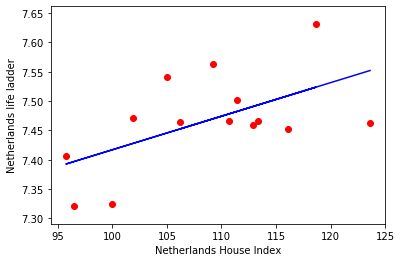

In [140]:
model2 = LinearRegression()

model2.fit(x_fit,y)
Y_pred = model2.predict(x_fit)

plt.scatter(x_fit, y, color = 'red')
plt.plot(x_fit, Y_pred, color = 'blue')
test = model2.score(x_fit, y)
print(test)

plt.xlabel("Netherlands House Index")
plt.ylabel("Netherlands life ladder")

plt.show()

## Plotly visualization

For the viusualization, we used plotly in order to be able to create interactive graphics so the user can play with them.

In [141]:
import plotly.graph_objects as go
from ipywidgets import widgets, interactive
from plotly.subplots import make_subplots


### Scatterplot with linear Regression

After importing the packages, we now create x equal to the first column of Netherlands_Analysis which is equal to the house price index of this country and y as one variable of the dataset. We could have take any variables from any dataset as it only initialize the graphs, after, each change will change the value ploted.

In [142]:
x_test = Netherlands_analysis.iloc[:,1]
y_test = Netherlands_analysis.iloc[:, 4]
x =  x_test
y = y_test

We create a dictionnary which the keys are the name of the countries and their items are their refering dataset. We use this dictionnary in order to print in our graph after the name of the country instead of the name of the dataset.

In [143]:
country = {"France":France_analysis, 
           "Netherlands":Netherlands_analysis, 
           "Austria":Austria_analysis,
           "Belgium":Belgium_analysis,
           "Luxembourg":Luxembourg_analysis,
           "Germany":Germany_analysis
          }

Once more, we create a dictionnary for each variable of the dataset by using their position. We do this because the names of the variables are the country name + an abbreviation of the variable name. With this, we will be able to use the variable full name when we're going to print the graph.

In [144]:
events = {"Exchanges rates":2,
         "Unemployment rate":3,
         "Life ladder":4,
         "Confidence in government":5,
         "Perception of corruption":6,
         "Stock market value":7,
         "Inflation rate":8,
         "Minimum wages":9,
         "Nominal exchanges rates":10,
         "Nominal effective exchanges rates":11,
         "Crime rate":12,
         "Urban crime rate":13,
         "Gross domestic product":14,
         "Life expectancy":15,
         "Nb of marriages":16,
         "Polution":17,
         "Electricity consumption":18,
         "Fertility":19}

Now we're going to create the graph.

In [145]:
Netherlands_analysis

,Year,Netherlands_houseIndex,Netherlands_exchRates,Netherlands_unemp,Netherlands_lifelad,Netherlands_conf,Netherlands_corrup,Netherlands_stock,Netherlands_infla,Netherlands_wages,Netherlands_Ner,Netherlands_NerEff,Netherlands_Crime,Netherlands_CriUrb,Netherlands_GDP,Netherlands_Life,Netherlands_Mar,Netherlands_Pol,Netherlands_elec,Netherlands_fert
0,2005,106.1950,0.0,5.9,7.463979,0.429007,0.571342,5.928356e+11,1.688130,22855.03,0.0,-0.6,17.6,24.85,40066.666667,81.32,68789.159,0.2103,8977.214100,1.710000
1,2006,110.7325,0.0,5.0,7.466531,0.589056,0.430646,7.795426e+11,1.101501,22851.51,0.0,0.0,17.6,24.85,40066.666667,81.32,68789.159,0.2103,9086.758400,1.720000
2,2007,116.0950,-0.1,4.2,7.451880,0.661946,0.445437,9.561576e+11,1.613859,23023.30,-0.1,1.1,17.6,24.85,37800.000000,81.32,68789.159,0.2103,9274.204600,1.720000
3,2008,118.6400,-0.1,3.7,7.631012,0.617429,0.418940,3.887208e+11,2.486502,23097.71,-0.1,2.3,14.8,24.85,39350.000000,80.50,74097.240,0.2103,9331.900300,1.770000
4,2009,113.3500,0.0,4.4,7.466531,0.589056,0.430646,5.591953e+11,1.189777,23573.39,0.0,1.9,21.7,29.80,37800.000000,80.90,72186.330,0.2210,9006.448800,1.790000
5,2010,111.4000,0.0,5.0,7.501876,0.636186,0.398592,6.610992e+11,1.275306,23643.53,0.0,-2.8,16.8,24.00,38470.000000,81.00,75466.220,0.2220,9264.832300,1.790000
6,2011,109.1900,0.0,5.0,7.563798,0.603367,0.359396,5.946365e+11,2.341070,23266.83,0.0,0.4,18.6,26.80,38960.000000,81.30,71639.500,0.1580,9275.752400,1.760000
7,2012,101.8600,0.0,5.8,7.470716,0.574514,0.433754,6.508112e+11,2.455548,23181.20,0.0,-2.1,18.3,25.00,38970.000000,81.20,70319.200,0.2290,8971.101300,1.720000
8,2013,95.7475,0.0,7.3,7.406550,0.542987,0.504530,8.178403e+11,2.506899,22895.61,0.0,1.9,18.1,21.50,39300.000000,81.40,64616.460,0.2180,8999.780900,1.680000
9,2014,96.5325,0.0,7.4,7.321188,0.525242,0.456948,7.865735e+11,0.976035,22998.15,0.0,0.9,18.5,26.10,39820.000000,81.80,65400.770,0.2010,8744.564500,1.710000


In [146]:
#First, we create two widgets:

#Textbox is a dropdown menu which contains the keys of the dictionnary events.
textbox = widgets.Dropdown(
       description='Event:   ',
    value='Inflation rate',
    options= events.keys()
)

#Countrybox is a dropdown menu which contains the keys of the dictionnary country.
countrybox = widgets.Dropdown(
    description='Country:   ',
    value='Netherlands',
    options= country.keys()
)

#We put those two widgets into a widget HBox.
container = widgets.HBox(children=[countrybox,textbox])

#Now we create two trace, the first one trace1 is a scatter of the values selected represented by points.
#We add hover infos as the year + the house price index.
trace1 = go.Scatter(x=x, y=y, 
                    mode='markers', 
                    marker_color = y,
                    marker_size = 15,
                    hoverinfo = 'text + x',
                    hovertext = Netherlands_analysis['Year'].unique())

#We create a second trace trace2 which contains a scatter in line format of the the house price index regarding y as the prediction
#done by the linear model. It will draw the linear regression line on our graphs.

trace2 = go.Scatter(
    x= Netherlands_analysis['Netherlands_houseIndex'], 
    y= Y_pred,
    mode = 'lines',
    hoverinfo = 'none')

#Now, we put in g those 2 traces. From now, our graph isn't interactive but after putting those two traces in g, we will be able
# to create a function to make it interactive.

g = go.FigureWidget(data=[trace1, trace2],
                    layout=go.Layout(
                        title=dict(
                            text='Netherlands house index price regarding Inflation rate'
                        ),
                        barmode='overlay',
                        showlegend = False
                    ))


In [147]:
#We create a function to change value regarding the textbox value and the countrybox value to be able
#to play with the country and the event selected.
def scatterchange(change):   
#As Austria and Luxembourg have value for their index price only from 2010 and 2007 respectively,
#we make sure to show only value for this time if Austria or Luxembourg is selected in the countrybox value.
    if countrybox.value == 'Austria':
        x_value = country[countrybox.value].iloc[5:,1]
        y_value = country[countrybox.value].iloc[5:,events[textbox.value]]
        x_fit2 = country[countrybox.value].iloc[5:,[1]]
        g.data[0].hovertext = Netherlands_analysis.loc[5:,'Year'].unique()
    elif countrybox.value == 'Luxembourg':
        x_value = country[countrybox.value].iloc[2:,1]
        y_value = country[countrybox.value].iloc[2:,events[textbox.value]]
        x_fit2 = country[countrybox.value].iloc[2:,[1]]
        g.data[0].hovertext = Netherlands_analysis.loc[2:,'Year'].unique()

#As all other countries contains values from 2005, we can select all values of the dataset.
    else:
        x_value = country[countrybox.value].iloc[:,1]
        y_value = country[countrybox.value].iloc[:,events[textbox.value]]
        x_fit2 = country[countrybox.value].iloc[:,[1]]
        g.data[0].hovertext = country[countrybox.value]['Year'].unique()

#Now, we initiate a linear model into the function based on x_fit2 define just above which is the house price index and y_value
# as the y input. We will compute the Y_pred2 in order to draw the regression line for each country and for each variable.
    linear = LinearRegression()
    linear.fit(x_fit2,y_value)
    Y_pred2= linear.predict(x_fit2)
#As we want to print the Rsquared (strenght of the relationship) in our graph, we compute it also and round it to make it 
#readable.
    Rsquared = round(linear.score(x_fit2,y_value),4)

#Now we're going to update g, which contains the trace1 and trace2 so we will update the graphs for eahc input of the
#countrybox and textbox.
    with g.batch_update():
        #here g.data[0] refers to the trace1 and g.data[1] so we update the value with x_value and y_value define above.
        g.data[0].x = x_value
        g.data[0].y = y_value
        g.data[1].x = x_value
        #here, we assign Y_pred2 computed each time there is a change in the texbox or countrybox
        g.data[1].y = Y_pred2
        #We make the x axis adaptive to the country.
        g.layout.xaxis.title = 'House index price of ' + str(countrybox.value)
        #And the y axis to the event selected.
        g.layout.yaxis.title = str(textbox.value)
        #And create a title for each country and for each event
        g.layout.title = str(countrybox.value) + ' house index price regarding ' + str(textbox.value)
        #As we have some missing values, R² might be equal to 1 but it's only because of missing values as 1 is impossible.
        if Rsquared == 1 :
            #So, if R² equal 1, we print a message on the regression line saying it's not relevant
            g.update_layout(
                showlegend=False,
                annotations=[
                    go.layout.Annotation(
                        x= float(x_fit2.mean()),
                        y= Y_pred2.mean(),
                        text= "R² =  " + str(Rsquared) + " due to missing value or inefficient data",
                        showarrow=True,
                        arrowhead=7,
                        ax=0,
                        ay=-50)])
        else:
            #else, we print, the value of the R² on the line.
            g.update_layout(
                showlegend=False,
                annotations=[
                    go.layout.Annotation(
                        x= float(x_fit2.mean()),
                        y= Y_pred2.mean(),
                        text="R² = " + str(Rsquared),
                        showarrow=True,
                        arrowhead=7,
                        ax=0,
                        ay=-50)])

#Now we assign the function with observe so each time countrybox or textbox values change, the function update the data.
        
textbox.observe(scatterchange, names="value")
countrybox.observe(scatterchange, names="value")

    So now, bellow we find an interactive graphs with values, regression line, R², title and subtitles interactive regarding the input.

In [148]:
#And we print the container containing the texbox & countrybox with g containing the graphs into the same cell.
widgets.VBox([container,
             g])

### Double bar chart for the Rsquared


Now, we're going to create two subplots for comparing at the same time the Rsquared of two country. We use to do so the dataset created before containg the Rsquared of each variable for each country. 

In [149]:
#We assign them the columns events corresponding to their index to use this column to print the event name on the graph.
FranceScore['Events'] = FranceScore.index
NetherlandsScore['Events'] = NetherlandsScore.index
BelgiumScore['Events'] = BelgiumScore.index
AustriaScore['Events'] = AustriaScore.index
LuxembourgScore['Events'] = LuxembourgScore.index
GermanyScore['Events'] = GermanyScore.index

In [150]:
#We create a dictionnary ScoreCountry to print the name of the country but selecting the dataset corresponding.
ScoreCountry = {"France":FranceScore, 
           "Netherlands":NetherlandsScore, 
           "Austria":AustriaScore,
           "Belgium":BelgiumScore,
           "Luxembourg":LuxembourgScore,
           "Germany":GermanyScore
          }

In [151]:
#We first initiate mixed as a figure widgets and define the layout with rows and cols to be able to put graphs inside.

mixed = go.FigureWidget(make_subplots(rows = 1, cols = 2))

#We add a first barchart horizontally with the position 1:1, and we assign the value of FranceScore dataset. It's only to 
#initiate the graphs as after it will be interactive.
mixed.add_trace(go.Bar(x=FranceScore['Score'], 
              y = FranceScore['Events'], 
              orientation = 'h',
              marker_color = FranceScore['Score'], 
              marker_colorscale = "Reds"),
              row = 1, col = 1)

#We add a second barchart for the second country we want to display at the position 1:2 (second column)
mixed.add_trace(go.Bar(x=NetherlandsScore['Score'], 
              y = NetherlandsScore['Events'], 
              orientation = 'h',
              marker_color = NetherlandsScore['Score'], 
              marker_colorscale = "Reds",
              hovertext = 'equal to the Rsquared',
              hoverinfo = 'x + text'),
              row = 1, col = 2)

#We update the size of the layout.
mixed.update_layout(height=600, width=1000, title_text="France Rsquared variables versus Netherlands", showlegend  = False)


#We now create two dropdown menu to select the two country we want to compare.

country1 = widgets.Dropdown(
    description='Country:   ',
    value='France',
    options= country.keys()
)

country2 = widgets.Dropdown(
    description='Country:   ',
    value='Netherlands',
    options= country.keys()
)

#We create also two checkbox widget. The first one will be used to switch the bar chart from horizontal to vertical.

Bar_horiz = widgets.Checkbox(
    description='Horizontal bar chart : ',
    value= True,
)

#The second one is to put both graphs with the same scale to have easier visualization.
Same_scale = widgets.Checkbox(
    description='Axis with the same scale :',
    value= False,
)

#And finally a slider to select the number of events to display on the graphs.
slider = widgets.FloatRangeSlider(
    min= 0,
    max=len(France_analysis.iloc[:,2:].columns),
    step= 1,
    readout=False,
    description='Nb of events')
slider.layout.width = '600px'

#We put the dropdown in one container and the checkbox in an other one.
containerCountries = widgets.HBox(children=[country1,country2])
containerOptions = widgets.HBox(children=[Bar_horiz, Same_scale])


def mixedfunc(change_mixed):

#This function will update value regarding the country inputed in each dropdown menu.
    
    x_country1 = ScoreCountry[country1.value]['Score']
    y_country1 = ScoreCountry[country1.value]['Events']
    x_country2 = ScoreCountry[country2.value]['Score']
    y_country2 = ScoreCountry[country2.value]['Events']



    with mixed.batch_update():
        

        mixed.layout.title = str(country1.value) + ' Rsquared variables versus ' + str(country2.value)

#As we define an option to change the graphs from horizontal to vertical and reverse, we need to update the data regarding
#this parameter. Because changing the orientation turn the x into y and reverse.
        if Bar_horiz.value ==  True:
            mixed.data[0].orientation = 'h'
            mixed.data[1].orientation = 'h'
            mixed.data[0].x = x_country1
            mixed.data[0].y = y_country1
            mixed.data[1].x = x_country2
            mixed.data[1].y = y_country2
            mixed.layout.xaxis.title = 'House index price of ' + str(country1.value)
            mixed.layout.yaxis.title = str(country1.value)
            mixed.layout.xaxis2.title = 'House index price of ' + str(country2.value)
            mixed.layout.yaxis2.title = str(country2.value)
            
            #The same scale define the range from 0 to 1 if it's true, else it takes the maximum value + 5% as the max range.
            if Same_scale.value == True:
                mixed.layout.xaxis.range = [0,1]
                mixed.layout.xaxis2.range = [0,1]
            else :
                mixed.layout.xaxis.range = [0,(max(ScoreCountry[country1.value]['Score'])*1.05)]
                mixed.layout.xaxis2.range = [0,(max(ScoreCountry[country2.value]['Score'])*1.05)]

          
            
        else:
            mixed.data[0].orientation = 'v'
            mixed.data[1].orientation = 'v'
            mixed.data[0].x = y_country1
            mixed.data[0].y = x_country1
            mixed.data[1].x = y_country2
            mixed.data[1].y = x_country2
            mixed.layout.yaxis.title = 'House index price of ' + str(country1.value)
            mixed.layout.xaxis.title = str(country1.value)
            mixed.layout.yaxis2.title = 'House index price of ' + str(country2.value)
            mixed.layout.xaxis2.title = str(country2.value)
            if Same_scale.value == True:
                mixed.layout.yaxis.range = [0,1]
                mixed.layout.yaxis2.range = [0,1]
            else :
                mixed.layout.yaxis.range = [0,(max(ScoreCountry[country1.value]['Score'])*1.05)]
                mixed.layout.yaxis2.range = [0,(max(ScoreCountry[country2.value]['Score'])*1.05)]

                       
#We now apply this function to all widgets we created so applying one change in one widgets will change the graphs.   
country1.observe(mixedfunc, names="value")
country2.observe(mixedfunc, names="value")
Bar_horiz.observe(mixedfunc, names="value")
Same_scale.observe(mixedfunc, names = "value")

#We finally create another function for the slider to select the number of event. The range of event is defined by y which
#is assign to the value of the slider bellow.

def update_range(y):
    if Bar_horiz.value ==  True:
        mixed.layout.yaxis.range = [y[0], y[1]]
        mixed.layout.yaxis2.range = [y[0], y[1]]

    else:
        mixed.layout.xaxis.range = [y[0], y[1]]
        mixed.layout.xaxis2.range = [y[0], y[1]]

        

widgets.VBox([containerCountries,
              containerOptions,
              interactive(update_range, y=slider),
             mixed])


So above, we now have an interactive graph with two bar charts in order to be able to compare the most important variable for the house index price per country.

## Map of the country

This map will display the variables information per year on a map, so we can see the unemployment rates per year per country for example

In [152]:
#We first need to create a function to rename the columns as we're going to use the analysis dataset in order to create a new dataset.
def renameEvents(value):
    value.columns = ["Year","House index price",
         "Exchanges rates",
         "Unemployment rate",
         "Life ladder",
         "Confidence in government",
         "Perception of corruption",
         "Stock market value",
         "Inflation rate",
         "Minimum wages",
         "Nominal exchanges rates",
         "Nominal effective exchanges rates",
         "Crime rate",
         "Urban crime rate",
         "Gross domestic product",
         "Life expectancy",
         "Nb of marriages",
         "Polution",
         "Electricity consumption",
         "Fertility",
         "Country",
         "Code"]



In [153]:
#For each country, we create a new dataset with the new columns name, and also we add two news columns
#to identify the country and the country code in order to be able to place them on a map.
France_Stack = France_analysis[:]
France_Stack['Country'] = 'France'
France_Stack['Code'] = 'FRA'
renameEvents(France_Stack)

Germany_Stack = Germany_analysis[:]
Germany_Stack['Country'] = 'Germany'
Germany_Stack['Code'] = 'DEU'
renameEvents(Germany_Stack)

Belgium_Stack = Belgium_analysis[:]
Belgium_Stack['Country'] = 'Belgium'
Belgium_Stack['Code'] = 'BEL'
renameEvents(Belgium_Stack)

Luxembourg_Stack = Luxembourg_analysis[:]
Luxembourg_Stack['Country'] = 'Luxembourg'
Luxembourg_Stack['Code'] = 'LUX'
renameEvents(Luxembourg_Stack)

Austria_Stack = Austria_analysis[:]
Austria_Stack['Country'] = 'Austria'
Austria_Stack['Code'] = 'AUT'
renameEvents(Austria_Stack)

Netherlands_Stack = Netherlands_analysis[:]
Netherlands_Stack['Country'] = 'Netherlands'
Netherlands_Stack['Code'] = 'NLD'
renameEvents(Netherlands_Stack)
Germany_Stack.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#inde

,Year,House index price,Exchanges rates,Unemployment rate,Life ladder,Confidence in government,Perception of corruption,Stock market value,Inflation rate,Minimum wages,...,Crime rate,Urban crime rate,Gross domestic product,Life expectancy,Nb of marriages,Polution,Electricity consumption,Fertility,Country,Code
0,2005,83.325,0.0,11.2,6.619550,0.321759,0.781007,1.202136e+12,1.546911,0.0,...,13.190909,28.45,34846.666667,80.69,388095.573,0.356,44906.6208,1.34,Germany,DEU
1,2006,83.000,-0.1,10.1,6.792368,0.495483,0.605641,1.637610e+12,1.577429,0.0,...,13.190909,28.45,34846.666667,80.69,388095.573,0.356,45397.2485,1.33,Germany,DEU
2,2007,81.225,-0.2,8.5,6.416820,0.349765,0.792179,2.105198e+12,2.298341,0.0,...,13.190909,28.45,30860.000000,80.69,388095.573,0.356,45516.4230,1.37,Germany,DEU
3,2008,82.325,-0.1,7.4,6.521790,0.357918,0.758266,1.110580e+12,2.628383,0.0,...,13.000000,28.45,31530.000000,80.20,377122.120,0.356,45363.1986,1.38,Germany,DEU
4,2009,83.000,-0.1,7.6,6.641493,0.519231,0.689931,1.292355e+12,0.312738,0.0,...,12.700000,27.90,30390.000000,80.30,378506.430,0.325,42756.5778,1.36,Germany,DEU


In [154]:
#Now, as we have the same columns name for all dataset, we can stack the data. Thanks to country and code columns, we
#can still identifiate which data correspond to which country.
Map_Country = pd.concat([France_Stack,Netherlands_Stack,Germany_Stack,Austria_Stack,Luxembourg_Stack,Belgium_Stack], axis=0)


In [155]:
Map_Country.head()

,Year,House index price,Exchanges rates,Unemployment rate,Life ladder,Confidence in government,Perception of corruption,Stock market value,Inflation rate,Minimum wages,...,Crime rate,Urban crime rate,Gross domestic product,Life expectancy,Nb of marriages,Polution,Electricity consumption,Fertility,Country,Code
0,2005,84.7175,0.0,8.9,7.093393,0.324884,0.687851,1.758513e+12,1.745869,19414.10,...,15.009091,29.67,32115.833333,82.22,243083.517,0.2062,36351.7627,1.94,France,FRA
1,2006,94.6050,0.0,8.8,6.582700,0.361353,0.699270,2.428252e+12,1.675125,19900.01,...,15.009091,29.67,32115.833333,82.22,243083.517,0.2062,36708.9424,2.00,France,FRA
2,2007,100.7025,-0.1,8.0,6.664774,0.373618,0.643763,2.740341e+12,1.487998,20101.51,...,15.009091,29.67,30330.000000,82.22,243083.517,0.2062,36630.6965,1.98,France,FRA
3,2008,101.6275,-0.1,7.4,7.008065,0.452659,0.668876,1.472407e+12,2.812862,20140.51,...,14.800000,29.67,30960.000000,81.40,265613.210,0.2062,37208.5985,2.01,France,FRA
4,2009,95.3250,0.0,9.1,6.283498,0.474449,0.654168,1.946185e+12,0.087620,20493.07,...,15.300000,30.90,29930.000000,81.50,251721.390,0.2050,35937.6612,2.00,France,FRA


In [156]:
#Now, we create a choropleth map with plotly, the locations are the country code, and the text are the countries names.

Year = 2005

#And a widget to choose the event such as above.

Worldevent = widgets.Dropdown(
       description='Event:   ',
    value='Inflation rate',
    options= events.keys()
)

data = [go.Choropleth(
    locations = Map_Country['Code'].unique(),
    z = Map_Country['Unemployment rate'],
    text = Map_Country['Country'].unique(),
    autocolorscale = True,
    reversescale = False,
    marker = go.choropleth.Marker(
        line = go.choropleth.marker.Line(
            color = 'rgb(180,180,180)',
            width = 2
        )),
    colorbar = go.choropleth.ColorBar(
        title = Worldevent.value + ' in ' + str(Year)),
)]

#We define the title regarding the selected value.

layout = go.Layout(
    title = go.layout.Title(
        text = str(Year) + ' value for ' + Worldevent.value
    ),
    geo = go.layout.Geo(
        showframe = False,
        showcoastlines = False,
        projection = go.layout.geo.Projection(
            type = 'equirectangular'
        )
    ),
    annotations = [go.layout.Annotation(
        x = 0.55,
        y = 0.1,
        xref = 'paper',
        yref = 'paper',
        text = 'Data only for 6 europeans countries',
        showarrow = False
    )]
)

mapWorld = go.FigureWidget(data = data, layout = layout)

#We create this function to update the slider of the year in order to be able to choose which year we want to display the data.

def update_yearmap(Year):
    mapWorld.data[0].z = Map_Country.loc[Map_Country['Year'] == Year,Worldevent.value]
    mapWorld.data[0].colorbar['title'] = Worldevent.value + ' in ' + str(Year)
    mapWorld.update_layout(title = str(Year) + ' value for ' + Worldevent.value)
    

slider_map = interactive(update_yearmap, Year=(2005, 2018, 1))

#And this function to update the data regarding the event selected.

def update_eventsmap(map_update):
    z = Map_Country.loc[Map_Country['Year'] == Year, Worldevent.value]
    mapWorld.data[0].colorbar['title'] = Worldevent.value + ' in ' + str(Year)
    mapWorld.update_layout(title = str(Year) + ' value for ' + Worldevent.value)
    
    with mapWorld.batch_update():
        mapWorld.data[0].z = z
        
#We apply the function and print the result.

Worldevent.observe(update_eventsmap, names = "value")

Worldcontainer = widgets.HBox(children=[Worldevent,slider_map])


widgets.VBox([Worldcontainer,
              mapWorld])



##### And here's the end of this project which put in light some variables regarding the house index price. With the usage of 18 variables, we were able to find some insights for the house index price market.